Apply iLQR to network

In [1]:
import jax.numpy as np
import numpy as onp
from jax import random

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("RdYlBu", 8)
import time

import sys
sys.path.append("../src/")
import ilqr_network

from importlib import reload
reload(ilqr_network)

/home/mkp127/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


<module 'ilqr_network' from '../src/ilqr_network.py'>

## Text network dynamics

In [2]:
N = 200
time_steps = 600
h0 = ilqr_network.data['xsp']
inputs = np.zeros((time_steps, N))
y, h = ilqr_network.rollout_jit(h0, inputs)

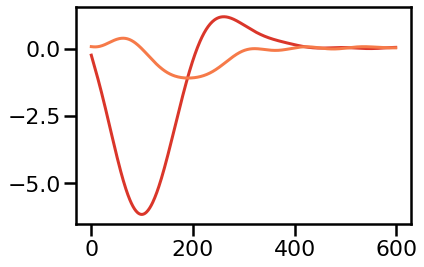

In [3]:
y, h = ilqr_network.rollout_batch(ilqr_network.params['x0'], np.zeros((8, time_steps, N)))
plt.plot(y[0])

## Optimize 

In [4]:
h0 = ilqr_network.params['x0'][0]
target_trj = ilqr_network.data['ytarget'][0]
u_trj = None
regu = 1e-2
lmbda = 1e-2

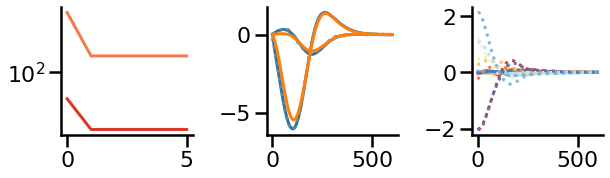

In [5]:
fig, ax = plt.subplots(1,3, figsize=(9,3))

# Correct init. state, no inputs needed
h0 = ilqr_network.params['x0'][0]
x_trj_new, u_trj_new, cost_trace = ilqr_network.run_ilqr(h0, target_trj, None, 5, regu, lmbda)

ax[0].semilogy(cost_trace)
ax[1].plot(target_trj, color='tab:blue')
ax[1].plot(x_trj_new[:,:2],":", color='gray')
ax[2].plot(u_trj_new[:,:8])

# From incorrect starting position
# Will need lots of inputs now
h0 = ilqr_network.data['xsp']
x_trj_new, u_trj_new, cost_trace = ilqr_network.run_ilqr(h0, target_trj, None, 5, regu, lmbda)
ax[0].plot(cost_trace)
ax[1].plot(x_trj_new[:,:2],color='tab:orange')
ax[2].plot(u_trj_new[:,:8],":")

sns.despine()
fig.tight_layout()

## Batch it

In [6]:
h0 = ilqr_network.params['x0']
target_trj = ilqr_network.data['ytarget']
u_trj = None
regu = 0.0
lmda = 1e-2

In [12]:
reload(ilqr_network)

<module 'ilqr_network' from '../src/ilqr_network.py'>

In [13]:
t0 = time.time()
h0 = ilqr_network.data['xsp']
x_trj_new, u_trj_new, cost_trace = ilqr_network.run_ilqr_batch(np.repeat(h0[None], 8, 0), target_trj, None, 
                                                               5, regu, lmbda)
t1 = time.time()
print(f"{t1 - t0:1.0f}")

14


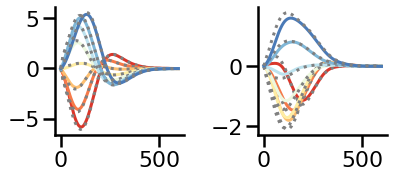

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
for i in range(8):
    for j in range(2):
        ax[j].plot(x_trj_new[i, :,j])
        ax[j].plot(target_trj[i,:,j],":", color='gray')
    
sns.despine()
fig.tight_layout()

## With prep. period

In [15]:
h0 = ilqr_network.data['xsp']
h0 = np.repeat(h0[None], 8, 0)
target_trj = ilqr_network.data['ytarget']
target_trj = np.concatenate((np.zeros((8, 300, 2)), target_trj), axis=1)
u_trj = None
steps = 5
regu = 0.0
lmda = 1e-1

20.99


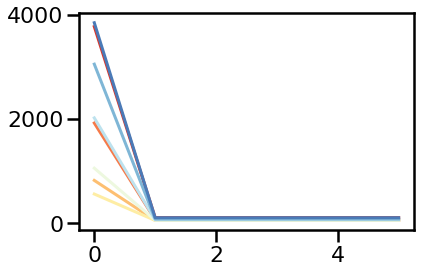

In [16]:
t0 = time.time()
x_trj_new, u_trj_new, cost_trace = ilqr_network.run_ilqr_batch(h0, target_trj, None, steps, regu, lmbda)
t1 = time.time()
print(f"{t1-t0:1.0f}")
plt.plot(cost_trace.T);

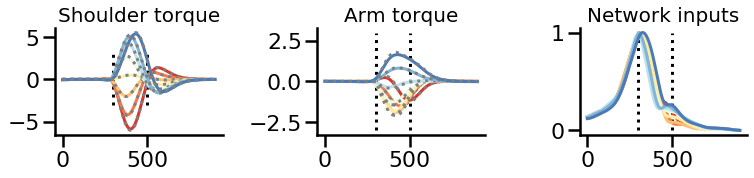

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(11,3))
for i in range(8):
    for j in range(2):
        ax[j].plot(x_trj_new[i, :,j])
        ax[j].plot(target_trj[i,:,j],":", color='gray')
    m = np.linalg.norm(u_trj_new[i], axis=-1)
    ax[2].plot(m / m.max())
    

ax[2].vlines(300, 0, 1, linestyles=":")
ax[2].vlines(500, 0, 1, linestyles=":")

for j in range(2):
    ax[j].vlines(300, -3, 3, linestyles=":")
    ax[j].vlines(500, -3, 3, linestyles=":")
    
fs = 20
ax[0].set_title("Shoulder torque", fontsize=fs)
ax[1].set_title("Arm torque",fontsize=fs)
ax[2].set_title("Network inputs", fontsize=fs)

sns.despine()
fig.tight_layout()

In [18]:
# Prep / move ratio
np.linalg.norm(u_trj_new[i,:300]) / np.linalg.norm(u_trj_new[i,300:600])

DeviceArray(0.74382347, dtype=float32)

## Compound reaches

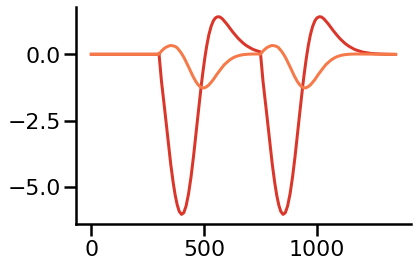

In [24]:
h0 = ilqr_network.data['xsp']
h0 = np.repeat(h0[None], 8, 0)
target_trj = ilqr_network.data['ytarget']
# 300 ms prep, reach one (cut off last 150 ms), reach 2
target_trj = np.concatenate((np.zeros((8, 300, 2)), target_trj[:,:-150], target_trj[:,0:]), axis=1)
u_trj = None
steps = 2
regu = 0.0
lmda = 1e-1
plt.plot(target_trj[0])
sns.despine()

9.92


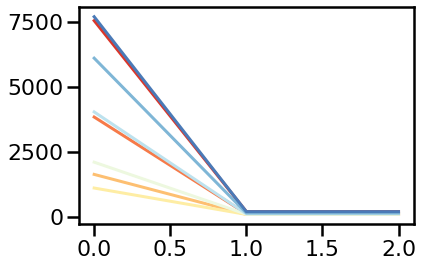

In [25]:
t0 = time.time()
x_trj_new, u_trj_new, cost_trace = ilqr_network.run_ilqr_batch(h0, target_trj, None, steps, regu, lmbda)
t1 = time.time()
print(f"{t1-t0:0.2f}")
plt.plot(cost_trace.T);

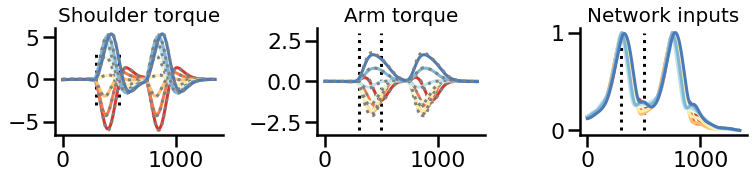

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(11,3))
for i in range(8):
    for j in range(2):
        ax[j].plot(x_trj_new[i, :,j])
        ax[j].plot(target_trj[i,:,j],":", color='gray')
    m = np.linalg.norm(u_trj_new[i], axis=-1)
    ax[2].plot(m / m.max())
    

ax[2].vlines(300, 0, 1, linestyles=":")
ax[2].vlines(500, 0, 1, linestyles=":")

for j in range(2):
    ax[j].vlines(300, -3, 3, linestyles=":")
    ax[j].vlines(500, -3, 3, linestyles=":")
    
fs = 20
ax[0].set_title("Shoulder torque", fontsize=fs)
ax[1].set_title("Arm torque",fontsize=fs)
ax[2].set_title("Network inputs", fontsize=fs)

sns.despine()
fig.tight_layout()

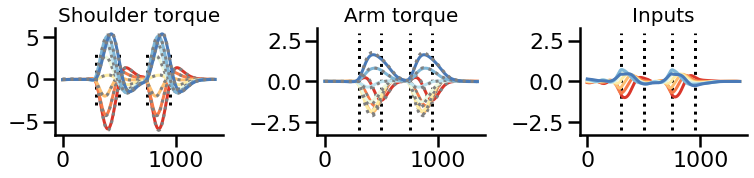

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(11,3))
for i in range(8):
    for j in range(2):
        ax[j].plot(x_trj_new[i, :,j])
        ax[j].plot(target_trj[i,:,j],":", color='gray')
    ax[2].plot(u_trj_new[i,:,0])
    

for j in range(3):
    ax[j].vlines(300, -3, 3, linestyles=":")
    ax[j].vlines(500, -3, 3, linestyles=":")
    ax[j].vlines(750, -3, 3, linestyles=":")
    ax[j].vlines(950, -3, 3, linestyles=":")
    
fs = 20
ax[0].set_title("Shoulder torque", fontsize=fs)
ax[1].set_title("Arm torque",fontsize=fs)
ax[2].set_title("Inputs", fontsize=fs)

sns.despine()
fig.tight_layout()